In [3]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pandas.io.json import json_normalize
import numpy as np
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
from scipy.stats import skew, kurtosis, entropy, iqr, median_abs_deviation
from scipy.spatial.distance import mahalanobis
import matplotlib.pyplot as plt

In [4]:
def open_datos(url):
    with open(url, 'r') as file:
        json_data = json.load(file)
    df = pd.DataFrame(json_data)
    return df


def find_signals(time_series):
    start_index = None
    max_abs_val = None
    signals = []
    
    for i, value in enumerate(time_series):
        if start_index is None and value <= -0.06:
            start_index = i
            max_abs_val = value
        elif start_index is not None:
            if value < max_abs_val:
                max_abs_val = value
            
            if value >= 0.03:
                signals.append((start_index, i, max_abs_val))
                start_index = None
                max_abs_val = None
    
    df = pd.DataFrame(signals, columns=['Start index', 'End index', 'Maximum Abs Value'])
    df["Duracion_Trade"]=df["End index"]-df["Start index"]
    return df

In [5]:
data=pd.read_csv("/Users/rogarciag/Desktop/AI_&_TRADING/ALGORITHMIC_TRADING/PRINCIPAL/NASINI/TRABAJOS_GENERAL/PROYECTO_TRADING/BASES_DE_DATOS/DATOS_CSV/AL30_COMPLETE_TASAS.csv")

In [6]:
data

,ticker,caucion_a_un_dia_ultimo_trade_tasa,caucion_a_un_dia_ultimo_trade_monto,COLOCAR_TASA_ABRIENDO_PLAZO_CERCANO_TASA,COLOCAR_TASA_ABRIENDO_PLAZO_LEJANO_TASA,TOMAR_TASA_ABRIENDO_PLAZO_CERCANO_TASA,TOMAR_TASA_ABRIENDO_PLAZO_LEJANO_TASA,time
0,AL30,67.25,183060.37,0.340921,0.368681,0.389028,0.408068,2023-04-19 15:02:32.504238
1,AL30,67.25,413023.04,0.340921,0.368681,0.389028,0.408068,2023-04-19 15:02:42.504503
2,AL30,67.24,573278.20,0.265913,0.312460,0.379653,0.286238,2023-04-19 15:02:52.522560
3,AL30,67.24,116231.00,0.275286,0.312460,0.379653,0.295612,2023-04-19 15:03:02.527854
4,AL30,67.24,63789.38,0.275286,0.312460,0.379653,0.295612,2023-04-19 15:03:12.557203
...,...,...,...,...,...,...,...,...
5605,AL30,69.00,200000.00,0.365928,0.070656,0.385699,0.381257,2023-04-21 20:00:47.752672
5606,AL30,69.00,200000.00,0.365928,0.070656,0.385699,0.381257,2023-04-21 20:01:20.689192
5607,AL30,69.00,200000.00,0.365928,0.070656,0.385699,0.381257,2023-04-21 20:02:58.460419
5608,AL30,69.00,200000.00,0.365928,0.070656,0.385699,0.381257,2023-04-21 20:04:34.512685


In [7]:
time_series = pd.DataFrame(columns=['date','spread'])
# modifiique los nombres así era más claro

#APLICAR EXPONENTE HURST
data["SPREAD_COLOCAR_PLAZO_CERCANO"] = data["COLOCAR_TASA_ABRIENDO_PLAZO_CERCANO_TASA"] - (data["caucion_a_un_dia_ultimo_trade_tasa"] / 100)
data["SPREAD_COLOCAR_PLAZO_LEJANO"] = data["COLOCAR_TASA_ABRIENDO_PLAZO_LEJANO_TASA"] - (data["caucion_a_un_dia_ultimo_trade_tasa"] / 100)

data["SPREAD_TOMAR_PLAZO_CERCANO"] =data["TOMAR_TASA_ABRIENDO_PLAZO_CERCANO_TASA"] - (data["caucion_a_un_dia_ultimo_trade_tasa"] / 100) 
data["SPREAD_TOMAR_PLAZO_LEJANO"] = data["TOMAR_TASA_ABRIENDO_PLAZO_LEJANO_TASA"] - (data["caucion_a_un_dia_ultimo_trade_tasa"] / 100)

data_general=data[["caucion_a_un_dia_ultimo_trade_tasa","SPREAD_COLOCAR_PLAZO_CERCANO","SPREAD_COLOCAR_PLAZO_LEJANO","SPREAD_TOMAR_PLAZO_CERCANO","SPREAD_TOMAR_PLAZO_LEJANO"]]

threshold_arbitrage=0

for index, row in data_general.iterrows():
    #Elegimos el mejor spread para colocar y tomar
    if  row["SPREAD_COLOCAR_PLAZO_CERCANO"] > row["SPREAD_COLOCAR_PLAZO_LEJANO"]:
         spread_colocar = row["SPREAD_COLOCAR_PLAZO_CERCANO"]
    else:
        spread_colocar = row["SPREAD_COLOCAR_PLAZO_LEJANO"]

    if row["SPREAD_TOMAR_PLAZO_CERCANO"] < row["SPREAD_TOMAR_PLAZO_LEJANO"]:
        spread_tomar = row["SPREAD_TOMAR_PLAZO_CERCANO"]

    else:
        spread_tomar = row["SPREAD_TOMAR_PLAZO_LEJANO"]

    # CASO NO PASA NADA
    if row["SPREAD_COLOCAR_PLAZO_CERCANO"] < threshold_arbitrage and row["SPREAD_COLOCAR_PLAZO_LEJANO"] < threshold_arbitrage  and row["SPREAD_TOMAR_PLAZO_CERCANO"] > threshold_arbitrage and row["SPREAD_TOMAR_PLAZO_LEJANO"] > threshold_arbitrage:
        time_series = pd.concat([time_series, pd.DataFrame({'date':[index],'spread':[0]})],ignore_index=True)
        
    elif spread_colocar > 0 and spread_tomar < 0:

        if spread_colocar > -spread_tomar:
            
            time_series = pd.concat([time_series, pd.DataFrame({'date':[index],'spread':[spread_colocar]})],ignore_index=True)
        
        else:

            time_series = pd.concat([time_series, pd.DataFrame({'date':[index],'spread':[spread_tomar]})],ignore_index=True)

    elif spread_colocar > 0:

        time_series = pd.concat([time_series, pd.DataFrame({'date':[index],'spread':[spread_colocar]})],ignore_index=True)

    elif spread_tomar < 0:

        time_series = pd.concat([time_series, pd.DataFrame({'date':[index],'spread':[spread_tomar]})],ignore_index=True)
    else:
        time_series = pd.concat([time_series, pd.DataFrame({'date':[index],'spread':[0]})],ignore_index=True)
        #print("hola")

In [32]:
x=time_series["spread"]
y=data_general=data[["SPREAD_COLOCAR_PLAZO_CERCANO","SPREAD_COLOCAR_PLAZO_LEJANO","SPREAD_TOMAR_PLAZO_CERCANO","SPREAD_TOMAR_PLAZO_LEJANO"]]

<Axes: >

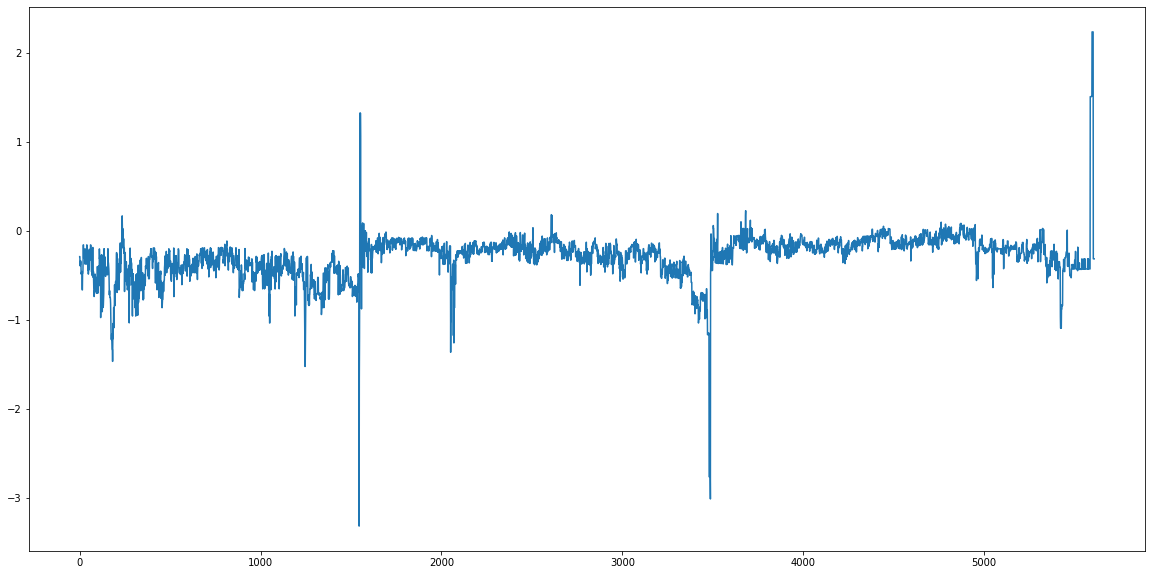

In [33]:
x.plot(figsize=(20,10))

# SCORE 1 PARA PARAMETRO NEGATIVO 

In [34]:
df=y
window_size = 60

score_df_negativo = pd.DataFrame(index=df.index, columns=df.columns, dtype=int)
for col in y.columns:
    rolling_mean = df[col].rolling(window=window_size).mean()
    rolling_var = df[col].rolling(window=window_size).var()
    rolling_skew = df[col].rolling(window=window_size).apply(lambda x: skew(x), raw=False)
    rolling_kurt = df[col].rolling(window=window_size).apply(lambda x: kurtosis(x), raw=False)
    rolling_entropy = df[col].rolling(window=window_size).apply(lambda x: entropy(x), raw=False)
    rolling_abs_deviation = df[col].rolling(window=window_size).apply(lambda x: np.mean(np.abs(x - np.mean(x))), raw=False)
    rolling_iqr = df[col].rolling(window=window_size).apply(lambda x: iqr(x), raw=False)
    rolling_mad = df[col].rolling(window=window_size).apply(lambda x: median_abs_deviation(x), raw=False)

    for i in range(window_size, len(df)):
        score = 0
        if df[col][i] < rolling_mean[i]:
            score += 1
        if df[col][i] > rolling_var[i]:
            score += 1 
        if df[col][i] > rolling_skew[i]:
            score += 1
        if df[col][i] > rolling_kurt[i]:
            score += 1
        if df[col][i] > rolling_entropy[i]:
            score += 1
        if df[col][i] > rolling_abs_deviation[i]:
            score += 1
        if df[col][i] > rolling_iqr[i]:
            score += 1
        if df[col][i] > rolling_mad[i]:
            score += 1

        score_df_negativo[col][i] = score

score_df_negativo.fillna(0, inplace=True)
score_df_negativo["Total"] = score_df_negativo["SPREAD_COLOCAR_PLAZO_CERCANO"] + score_df_negativo["SPREAD_COLOCAR_PLAZO_LEJANO"] + score_df_negativo["SPREAD_TOMAR_PLAZO_CERCANO"] + score_df_negativo["SPREAD_TOMAR_PLAZO_LEJANO"]

# SCORE 2 PARAMETRO POSITIVO

In [35]:
df=y
window_size = 60

# Create a new dataframe to store the scores
score_df_positivo = pd.DataFrame(index=df.index, columns=df.columns, dtype=int)

# Loop through the dataframe columns
for col in y.columns:
    # Calculate rolling metrics
    rolling_mean = df[col].rolling(window=window_size).mean()
    rolling_var = df[col].rolling(window=window_size).var()
    rolling_skew = df[col].rolling(window=window_size).apply(lambda x: skew(x), raw=False)
    rolling_kurt = df[col].rolling(window=window_size).apply(lambda x: kurtosis(x), raw=False)
    rolling_entropy = df[col].rolling(window=window_size).apply(lambda x: entropy(x), raw=False)
    rolling_abs_deviation = df[col].rolling(window=window_size).apply(lambda x: np.mean(np.abs(x - np.mean(x))), raw=False)
    rolling_iqr = df[col].rolling(window=window_size).apply(lambda x: iqr(x), raw=False)
    rolling_mad = df[col].rolling(window=window_size).apply(lambda x: median_abs_deviation(x), raw=False)


    # Calculate scores
    for i in range(window_size, len(df)):
        score = 0
        if df[col][i] > rolling_mean[i]:
            score += 1
        if df[col][i] < rolling_var[i]:
            score += 1 
        if df[col][i] < rolling_skew[i]:
            score += 1
        if df[col][i] < rolling_kurt[i]:
            score += 1
        if df[col][i] < rolling_entropy[i]:
            score += 1
        if df[col][i] < rolling_abs_deviation[i]:
            score += 1
        if df[col][i] < rolling_iqr[i]:
            score += 1
        if df[col][i] < rolling_mad[i]:
            score += 1

        score_df_positivo[col][i] = score

score_df_positivo.fillna(0, inplace=True)
score_df_positivo["Total"] = score_df_positivo["SPREAD_COLOCAR_PLAZO_CERCANO"] + score_df_positivo["SPREAD_COLOCAR_PLAZO_LEJANO"] + score_df_positivo["SPREAD_TOMAR_PLAZO_CERCANO"] + score_df_positivo["SPREAD_TOMAR_PLAZO_LEJANO"]

In [36]:
final_df=pd.DataFrame()
final_df["Total_Spread"]=x
final_df["Total_Score_Parametro_1_negativo"]=score_df_negativo["Total"]
final_df["Total_Score_Parametro_2_positivo"]=score_df_positivo["Total"]

In [37]:
final_df

,Total_Spread,Total_Score_Parametro_1_negativo,Total_Score_Parametro_2_positivo
0,-0.283472,0.0,0.0
1,-0.283472,0.0,0.0
2,-0.386162,0.0,0.0
3,-0.376788,0.0,0.0
4,-0.376788,0.0,0.0
...,...,...,...
5605,-0.308743,6.0,26.0
5606,-0.308743,6.0,26.0
5607,-0.308743,6.0,26.0
5608,-0.308743,6.0,26.0


In [38]:
time_series = final_df["Total_Spread"]
result = find_signals(time_series)

In [39]:
result

,Start index,End index,Maximum Abs Value,Duracion_Trade
0,0,234,-1.460979,234
1,237,238,-0.082741,1
2,240,1549,-3.311920,1309
3,1551,1552,-0.211301,1
4,1554,1563,-0.871009,9
5,1565,1570,-0.399987,5
6,1571,2506,-1.358197,935
7,2507,2608,-0.376510,101
8,2615,3503,-3.006852,888
9,3507,3527,-0.357448,20


In [13]:
result["Duracion_Trade"].mean()

160.44117647058823

# VISUALIZACION TRADES

<Axes: >

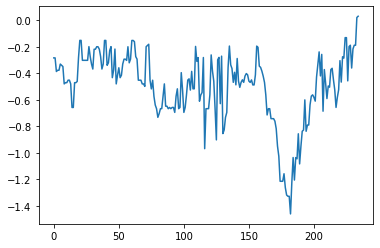

In [14]:
final_df["Total_Spread"][0:235].plot()

<Axes: >

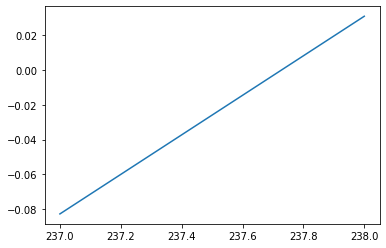

In [15]:
final_df["Total_Spread"][237:239].plot()

<Axes: >

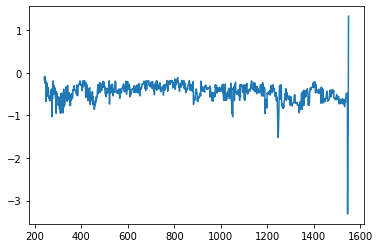

In [16]:
final_df["Total_Spread"][240:1550].plot()

<Axes: >

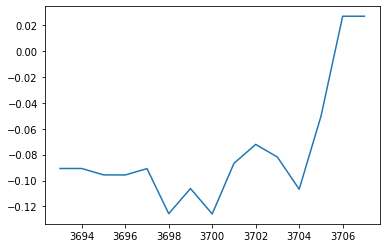

In [17]:
final_df["Total_Spread"][3693:3708].plot()

# DETECCION TRADE CON PUNTAJE

In [18]:
df_1 = result
df_2 = final_df["Total_Score_Parametro_1_negativo"]
indices = df_1["Start index"].values
df_score_spread = df_2.loc[indices]

In [19]:
df_score_filtrado=pd.DataFrame(df_score_spread)
result["Score_Inicio_Trade"]=df_score_filtrado["Total_Score_Parametro_1_negativo"].values

In [22]:
result_sorted = result.sort_values('Maximum Abs Value', ascending=True)
result_sorted

,Start index,End index,Maximum Abs Value,Duracion_Trade,Score_Inicio_Trade
2,240,1549,-3.311920,1309,11.0
8,2615,3503,-3.006852,888,6.0
0,0,234,-1.460979,234,0.0
6,1571,2506,-1.358197,935,6.0
33,5326,5587,-1.087408,261,5.0
4,1554,1563,-0.871009,9,7.0
32,4952,5324,-0.631199,372,11.0
5,1565,1570,-0.399987,5,6.0
10,3528,3655,-0.377281,127,9.0
7,2507,2608,-0.376510,101,9.0
